# Bond Option Pricing using Black-Karasinski Model

Value an option on a coupon paying bond using the Black-Karasinski model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
from financepy.utils import *
from financepy.market.curves import *
from financepy.products.rates import *
from financepy.models import *
from financepy.products.bonds import *

####################################################################
# FINANCEPY BETA Version 0.200 - This build:  09 Jul 2021 at 15:18 #
# **** NEW PEP8 COMPLIANT VERSION -- PLEASE UPDATE YOUR CODE  **** #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
# For info and disclaimer - https://github.com/domokane/FinancePy  #
#      Send any bug reports or comments to quant@financepy.com     #
####################################################################



## Bond Option Valuation

In [3]:
valuation_date = Date(1, 12, 2019)
settlement_date = valuation_date

Set up discount curve

In [5]:
dcType = DayCountTypes.THIRTY_360_BOND
fixedFreq = FrequencyTypes.SEMI_ANNUAL
swapType = SwapTypes.PAY
swap1 = IborSwap(settlement_date,"1Y",swapType,0.0500,fixedFreq,dcType)
swap2 = IborSwap(settlement_date,"3Y",swapType,0.0500,fixedFreq,dcType)
swap3 = IborSwap(settlement_date,"5Y",swapType,0.0500,fixedFreq,dcType)
swap4 = IborSwap(settlement_date,"7Y",swapType,0.0500,fixedFreq,dcType)
swap5 = IborSwap(settlement_date,"10Y",swapType,0.0500,fixedFreq,dcType)
swaps = [swap1, swap2, swap3, swap4, swap5]

libor_curve = IborSingleCurve(valuation_date, [], [], swaps)

## Set up the Bond Option

First create the bond

In [6]:
issue_date = Date(1, 12, 2015)
maturity_date = Date(1, 12, 2029)
coupon = 0.05
freq_type = FrequencyTypes.SEMI_ANNUAL
accrual_type = DayCountTypes.THIRTY_360_BOND
bond = Bond(issue_date, maturity_date, coupon, freq_type, accrual_type)

Let's first price the bond on the libor curve

In [7]:
price = bond.clean_price_from_discount_curve(settlement_date, libor_curve)
print("Fixed Income Price:", price)

Fixed Income Price: 99.99996342785461


Then define and create the option

In [8]:
expiry_date = settlement_date.add_tenor("18m")
strike_price = 90.0
face = 100.0
option_type = BondOptionTypes.AMERICAN_CALL

### Black Karasinski Model

Set the model parameters

In [9]:
sigma = 0.20
a = 0.05
bkModel = BKTree(sigma, a)

In [10]:
strikes = [80, 85, 90, 95, 100, 105, 110, 115, 120]

In [11]:
for K in strikes:
    europeanCallBondOption = BondOption(bond, expiry_date, K, face, OptionTypes.EUROPEAN_CALL)
    v_ec = europeanCallBondOption.value(settlement_date, libor_curve, bkModel)
    americanCallBondOption = BondOption(bond, expiry_date, K, face, OptionTypes.AMERICAN_CALL)
    v_ac = americanCallBondOption.value(settlement_date, libor_curve, bkModel)
    europeanPutBondOption = BondOption(bond, expiry_date, K, face, OptionTypes.EUROPEAN_PUT)
    v_ep = europeanPutBondOption.value(settlement_date, libor_curve, bkModel)
    americanPutBondOption = BondOption(bond, expiry_date, K, face, OptionTypes.AMERICAN_PUT)
    v_ap = americanPutBondOption.value(settlement_date, libor_curve, bkModel)
    
    print("K: %9.5f EUR_CALL: %9.5f  AMER_CALL: %9.5f  EUR_PUT: %9.5f  AMER_PUT: %9.5f" %(K, v_ec, v_ac, v_ep, v_ap))

K:  80.00000 EUR_CALL:  18.57681  AMER_CALL:  19.99996  EUR_PUT:   0.01048  AMER_PUT:   0.01112
K:  85.00000 EUR_CALL:  13.98129  AMER_CALL:  14.99996  EUR_PUT:   0.05829  AMER_PUT:   0.06172
K:  90.00000 EUR_CALL:   9.51980  AMER_CALL:  10.17521  EUR_PUT:   0.24015  AMER_PUT:   0.26005
K:  95.00000 EUR_CALL:   5.53971  AMER_CALL:   5.91742  EUR_PUT:   0.90339  AMER_PUT:   0.97533
K: 100.00000 EUR_CALL:   2.44103  AMER_CALL:   2.63522  EUR_PUT:   2.44806  AMER_PUT:   2.65325
K: 105.00000 EUR_CALL:   0.73622  AMER_CALL:   0.79655  EUR_PUT:   5.38659  AMER_PUT:   5.80863
K: 110.00000 EUR_CALL:   0.11512  AMER_CALL:   0.12490  EUR_PUT:   9.40882  AMER_PUT:  10.12631
K: 115.00000 EUR_CALL:   0.00673  AMER_CALL:   0.00722  EUR_PUT:  13.94377  AMER_PUT:  15.00004
K: 120.00000 EUR_CALL:   0.00006  AMER_CALL:   0.00006  EUR_PUT:  18.58044  AMER_PUT:  20.00004


## Convergence Testing - Black-Karasinski

It is important that the tree price is stable to the number of tree steps. This can be a challenge when pricing American optionality on bonds due to the payment of coupons and the effect of accrued interest on the clean bond price.

In [12]:
discount_curve = DiscountCurveFlat(valuation_date, 0.05)

In [13]:
issue_date = Date(1, 9, 2004)
maturity_date = Date(1, 9, 2025)
coupon = 0.05
freq_type = FrequencyTypes.ANNUAL
accrual_type = DayCountTypes.ACT_ACT_ICMA
bond = Bond(issue_date, maturity_date, coupon, freq_type, accrual_type)
expiry_date = settlement_date.add_tenor("18m")
face = 100.0

In [14]:
num_stepsVector = range(50, 500, 10)

In [15]:
sigma = 0.00001
a = 0.05

In [16]:
K = 102.0

In [17]:
vec_ec = []
vec_ac = []
vec_ep = []
vec_ap = []

for num_steps in num_stepsVector:
    
    bkModel = BKTree(sigma, a, num_steps)
    
    europeanCallBondOption = BondOption(bond, expiry_date, K, face, OptionTypes.EUROPEAN_CALL)
    v_ec = europeanCallBondOption.value(settlement_date, discount_curve, bkModel)

    americanCallBondOption = BondOption(bond, expiry_date, K, face, OptionTypes.AMERICAN_CALL)
    v_ac = americanCallBondOption.value(settlement_date, discount_curve, bkModel)
    
    europeanPutBondOption = BondOption(bond, expiry_date, K, face, OptionTypes.EUROPEAN_PUT)
    v_ep = europeanPutBondOption.value(settlement_date, discount_curve, bkModel)
    
    americanPutBondOption = BondOption(bond, expiry_date, K, face, OptionTypes.AMERICAN_PUT)
    v_ap = americanPutBondOption.value(settlement_date, discount_curve, bkModel)
    
    # print("%d %9.5f %9.5f %9.5f %9.5f"%(num_steps, v_ec, v_ac, v_ep, v_ap))
    vec_ec.append(v_ec)
    vec_ac.append(v_ac)
    vec_ep.append(v_ep)
    vec_ap.append(v_ap)

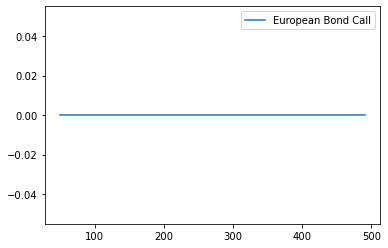

In [18]:
plt.plot(num_stepsVector,vec_ec, label="European Bond Call")
plt.legend();

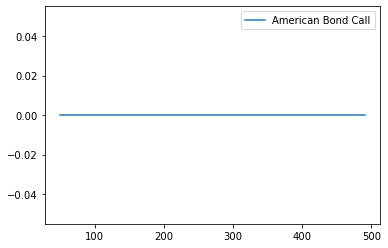

In [19]:
plt.plot(num_stepsVector,vec_ac, label="American Bond Call")
plt.legend();

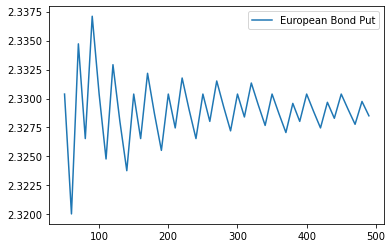

In [20]:
plt.plot(num_stepsVector,vec_ep, label="European Bond Put")
plt.legend();

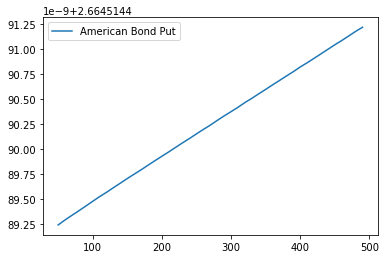

In [21]:
plt.plot(num_stepsVector,vec_ap, label="American Bond Put")
plt.legend();

Copyright (c) 2020 Dominic O'Kane